In [ ]:
import os
count=0;
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gitpython
import git
git.Repo.clone_from('https://github.com/seymanurakti/fight-detection-surv-dataset', '/content/drive/MyDrive/parkavi')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


<git.repo.base.Repo '/content/drive/MyDrive/parkavi/.git'>

In [ ]:
for filename in os.listdir('/content/drive/MyDrive/parkavi/fight'):
  #print(filename)
  vidObj = cv2.VideoCapture('/content/drive/MyDrive/parkavi/fight/'+filename)
  while True:
        success, image = vidObj.read()
        #print(success)
        # Saves the frames with frame-count
        if success:
          cv2.resize(image,(240,240));
          cv2.imwrite("/content/drive/MyDrive/parkavi/Dataset/fight1/frame%d.jpg" % count, image)
          count += 1
        else:
          break
  vidObj.release()
  cv2.destroyAllWindows()

In [ ]:
count=0

In [ ]:
for filename in os.listdir('/content/drive/MyDrive/parkavi/noFight'):
  #print(filename)
  vidObj = cv2.VideoCapture('/content/drive/MyDrive/parkavi/noFight/'+filename)
  while True:
        success, image = vidObj.read()
        #print(success)
        # Saves the frames with frame-count
        if success:
          cv2.resize(image,(240,240));
          cv2.imwrite("/content/drive/MyDrive/parkavi/Dataset/nonfight1/frame%d.jpg" % count, image)
          count += 1
        else:
          break
  vidObj.release()
  cv2.destroyAllWindows()

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
#from data import DataSet
import os.path

In [ ]:
import tensorflow as tf
from keras import backend as K

# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

# Configure Keras to use the GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# Rest of your Keras code that utilizes GPU


GPU Available: True


In [ ]:
def get_model(weights='imagenet'):
    # create the base pre-trained model
    base_model = InceptionV3(weights=weights, include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer
    predictions = Dense(2, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
import shutil

location="/content/drive/MyDrive/parkavi/Dataset"
path = os.path.join(location, '.ipynb_checkpoints')
print(path)
# removing directory
shutil.rmtree(path)

/content/drive/MyDrive/parkavi/Dataset/.ipynb_checkpoints


In [ ]:
def get_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/parkavi/Dataset/',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/parkavi/Dataset/',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

    return train_generator, validation_generator

model = get_model()
generators = get_generators()


Found 17120 images belonging to 2 classes.
Found 17120 images belonging to 2 classes.


In [ ]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join('data', 'checkpoints', 'inception.{epoch:03d}.hdf5'),
    verbose=1,
    save_best_only=True)

# Helper: Stop when we stop learning.
early_stopper = EarlyStopping(patience=10)

# Helper: TensorBoard
tensorboard = TensorBoard(log_dir=os.path.join('data', 'logs'))

In [ ]:
def train_model(model, nb_epoch, generators, callbacks=[]):
    train_generator =generators
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=nb_epoch,
        callbacks=callbacks)
    return model

In [ ]:
def freeze_all_but_top(model):
    """Used to train just the top layers of the model."""
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in model.layers[:-2]:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def freeze_all_but_mid_and_top(model):
    """After we fine-tune the dense layers, train deeper."""
    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 172 layers and unfreeze the rest:
    for layer in model.layers[:172]:
        layer.trainable = False
    for layer in model.layers[172:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(
        optimizer=SGD(lr=0.0001, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy'])

    return model

In [ ]:
train_generator, validation_generator = get_generators()  # Separate generators for training and validation data

model = get_model()
model = freeze_all_but_top(model)
model = train_model(model, 10,train_generator,
                        [checkpointer, early_stopper, tensorboard])

Found 17120 images belonging to 2 classes.
Found 17120 images belonging to 2 classes.


<ipython-input-43-0dcf1421f9ac>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.1010 - accuracy: 0.6072

100/100 [==============================] - 118s 1s/step - loss: 1.1010 - accuracy: 0.6072
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5915 - accuracy: 0.6938

100/100 [==============================] - 106s 1s/step - loss: 0.5915 - accuracy: 0.6938
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.7356

100/100 [==============================] - 106s 1s/step - loss: 0.5351 - accuracy: 0.7356
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.7675

100/100 [==============================] - 104s 1s/step - loss: 0.4705 - accuracy: 0.7675
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.7828

100/100 [==============================] - 105s 1s/step - loss: 0.4308 - accuracy: 0.7828
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8125

100/100 [==============================] - 103s 1s/step - loss: 0.3900 - accuracy: 0.8125
Epoch 7/10
100/100 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8241

100/100 [==============================] - 103s 1s/step - loss: 0.3704 - accuracy: 0.8241
Epoch 8/10
100/100 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8475

100/100 [==============================] - 104s 1s/step - loss: 0.3427 - accuracy: 0.8475
Epoch 9/10
100/100 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.8534

100/100 [==============================] - 107s 1s/step - loss: 0.3202 - accuracy: 0.8534
Epoch 10/10
100/100 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8803

100/100 [==============================] - 106s 1s/step - loss: 0.2809 - accuracy: 0.8803


In [ ]:
os.chdir('/content/drive/MyDrive/parkavi')

In [ ]:
model.save('model1.h5')

In [ ]:
for file in os.listdir('/content/drive/MyDrive/parkavi/Dataset'):
    print('/content/drive/MyDrive/parkavi/Dataset/'+file)

/content/drive/MyDrive/parkavi/Dataset/nonfight1
/content/drive/MyDrive/parkavi/Dataset/fight1


In [ ]:
model = freeze_all_but_mid_and_top(model)
model = train_model(model, 10,train_generator,
                        [checkpointer, early_stopper, tensorboard])

<ipython-input-43-0dcf1421f9ac>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.4679 - accuracy: 0.7844 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 119s 1s/step - loss: 0.4679 - accuracy: 0.7844 - top_k_categorical_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8553 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 109s 1s/step - loss: 0.3242 - accuracy: 0.8553 - top_k_categorical_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8875 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 107s 1s/step - loss: 0.2787 - accuracy: 0.8875 - top_k_categorical_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9028 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 106s 1s/step - loss: 0.2472 - accuracy: 0.9028 - top_k_categorical_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9187 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 105s 1s/step - loss: 0.2244 - accuracy: 0.9187 - top_k_categorical_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9156 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 105s 1s/step - loss: 0.2169 - accuracy: 0.9156 - top_k_categorical_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.9328 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 106s 1s/step - loss: 0.1834 - accuracy: 0.9328 - top_k_categorical_accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9428 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 107s 1s/step - loss: 0.1592 - accuracy: 0.9428 - top_k_categorical_accuracy: 1.0000
Epoch 9/10
100/100 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9409 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 105s 1s/step - loss: 0.1569 - accuracy: 0.9409 - top_k_categorical_accuracy: 1.0000
Epoch 10/10
100/100 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9563 - top_k_categorical_accuracy: 1.0000

100/100 [==============================] - 106s 1s/step - loss: 0.1433 - accuracy: 0.9563 - top_k_categorical_accuracy: 1.0000


In [ ]:
model.save('model2.h5')

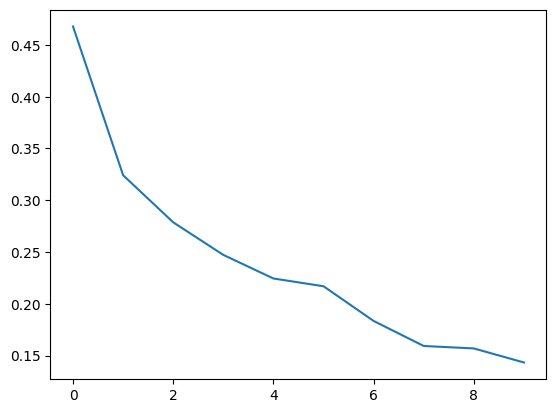

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])

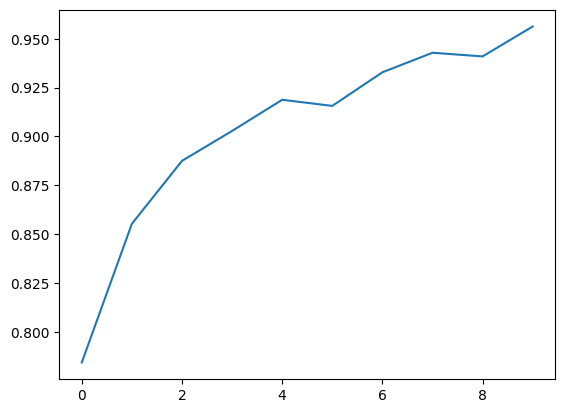

In [ ]:
  plt.plot(model.history.history['accuracy'])

In [ ]:
count=0
#for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
  #print(filename)
vidObj = cv2.VideoCapture('/content/drive/MyDrive/parkavi/fight/fi008.mp4')
print(vidObj)
while True:
        success, image = vidObj.read()
        #print(success)
        # Saves the frames with frame-count
        if success:
          cv2.resize(image,(299,299));
          cv2.imwrite("/content/drive/MyDrive/parkavi/tf/frame%d.jpg" % count, image)
          count += 1
        else:
          break
vidObj.release()
cv2.destroyAllWindows()

< cv2.VideoCapture 0x7fdfa247f070>


In [ ]:
count=0
#for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
  #print(filename)
vidObj = cv2.VideoCapture('/content/drive/MyDrive/parkavi/noFight/nofi008.mp4')
print(vidObj)
while True:
        success, image = vidObj.read()
        #print(success)
        # Saves the frames with frame-count
        if success:
          cv2.resize(image,(299,299));
          cv2.imwrite("/content/drive/MyDrive/parkavi/tnf/frame%d.jpg" % count, image)
          count += 1
        else:
          break
vidObj.release()
cv2.destroyAllWindows()

< cv2.VideoCapture 0x7fdfa247c4f0>


In [ ]:
import numpy as np

In [ ]:

from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/parkavi/model2.h5')

In [ ]:
import cv2,os

1/1 [==============================] - 0s 32ms/step
[[7.0672104e-04 9.9929321e-01]]


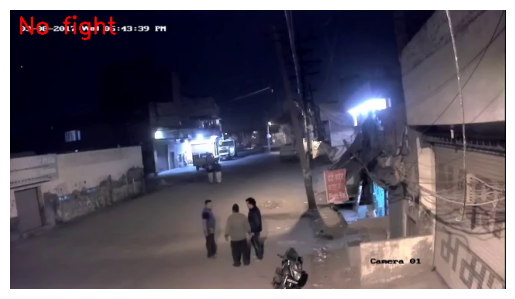

1/1 [==============================] - 0s 30ms/step
[[6.6036097e-04 9.9933964e-01]]


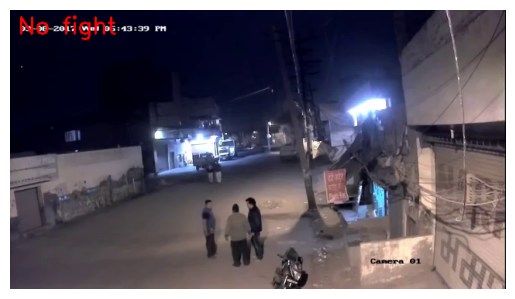

1/1 [==============================] - 0s 33ms/step
[[8.7059767e-04 9.9912947e-01]]


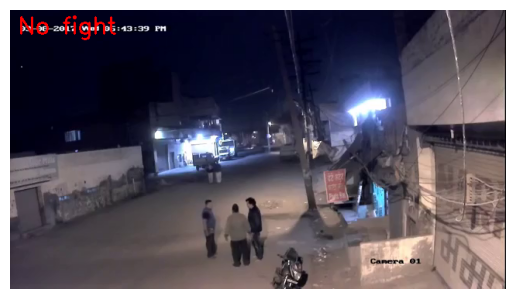

1/1 [==============================] - 0s 30ms/step
[[6.365664e-04 9.993635e-01]]


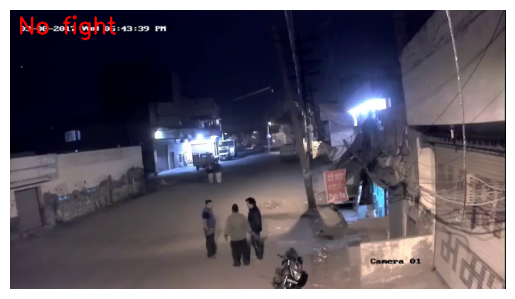

1/1 [==============================] - 0s 29ms/step
[[0.00131582 0.9986842 ]]


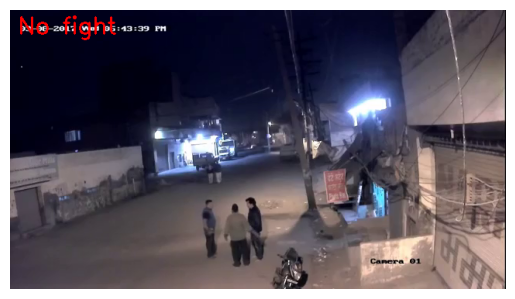

1/1 [==============================] - 0s 30ms/step
[[0.00148163 0.9985184 ]]


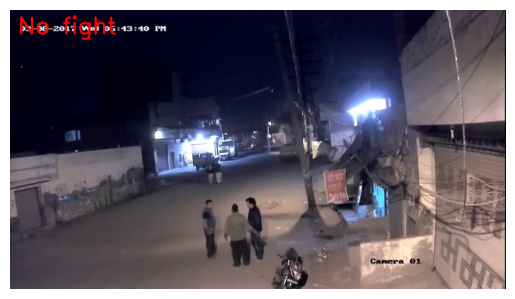

1/1 [==============================] - 0s 36ms/step
[[0.00123622 0.9987638 ]]


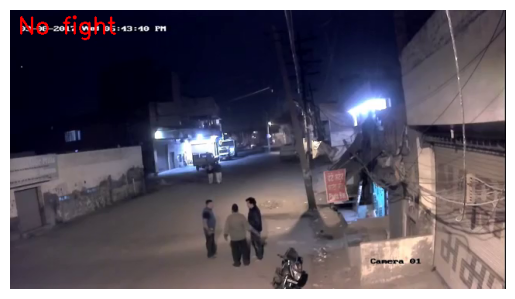

1/1 [==============================] - 0s 33ms/step
[[9.8705816e-04 9.9901295e-01]]


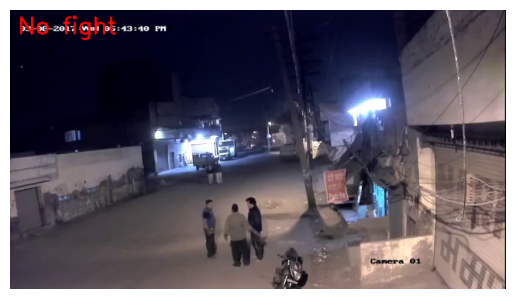

1/1 [==============================] - 0s 33ms/step
[[6.6085515e-04 9.9933916e-01]]


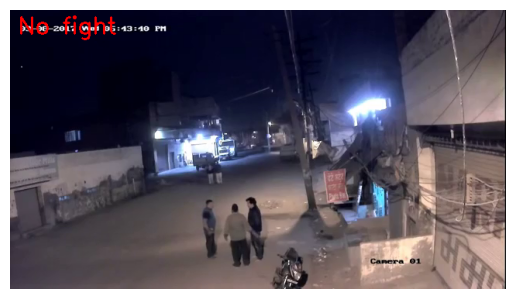

1/1 [==============================] - 0s 32ms/step
[[0.00101475 0.99898523]]


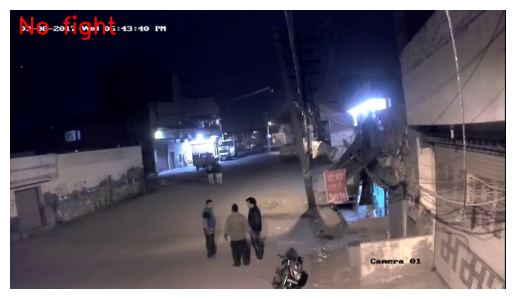

1/1 [==============================] - 0s 31ms/step
[[7.0843316e-04 9.9929154e-01]]


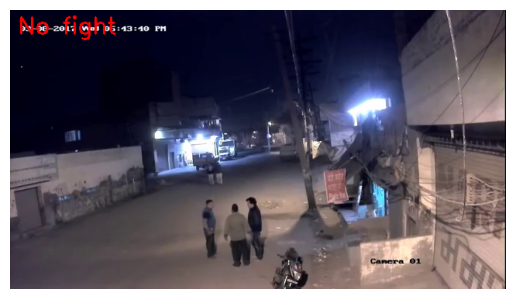

1/1 [==============================] - 0s 33ms/step
[[0.00103721 0.99896276]]


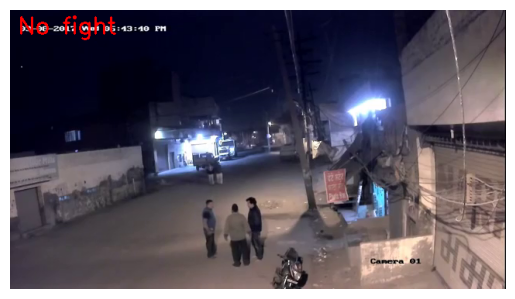

1/1 [==============================] - 0s 33ms/step
[[0.00146302 0.99853694]]


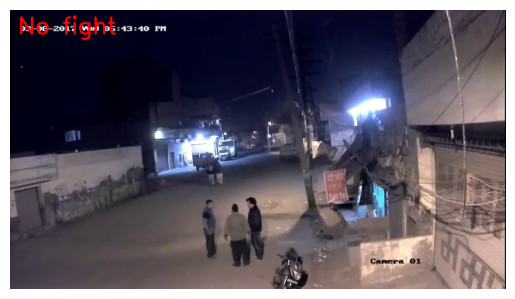

1/1 [==============================] - 0s 40ms/step
[[0.00131226 0.9986877 ]]


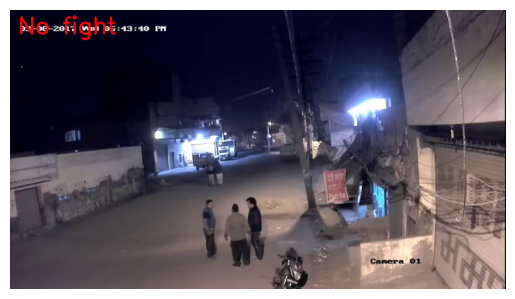

1/1 [==============================] - 0s 58ms/step
[[0.00164993 0.99835014]]


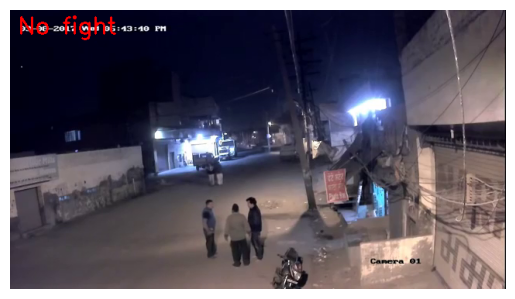

1/1 [==============================] - 0s 37ms/step
[[0.0019566 0.9980434]]


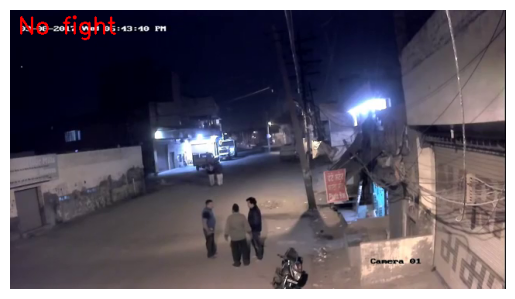

1/1 [==============================] - 0s 40ms/step
[[0.00112102 0.998879  ]]


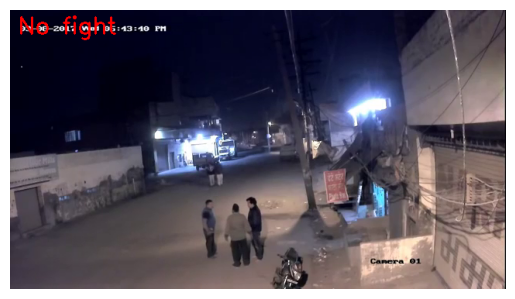

1/1 [==============================] - 0s 42ms/step
[[6.4473489e-04 9.9935526e-01]]


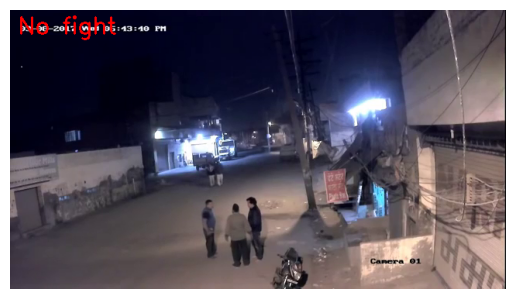

1/1 [==============================] - 0s 42ms/step
[[7.6988671e-04 9.9923015e-01]]


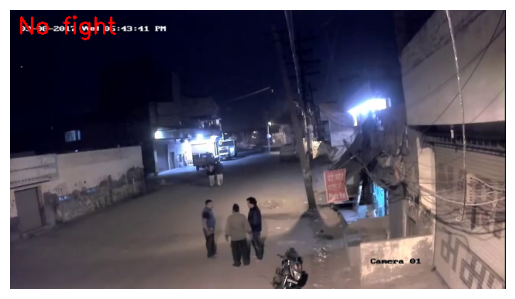

1/1 [==============================] - 0s 38ms/step
[[5.9265294e-04 9.9940741e-01]]


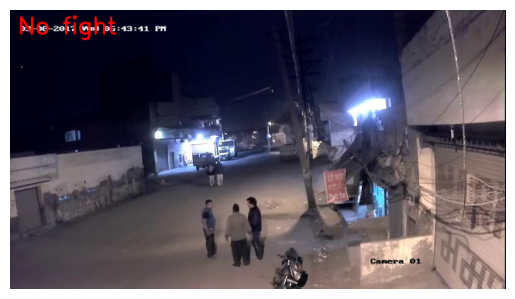

1/1 [==============================] - 0s 44ms/step
[[7.2786032e-04 9.9927217e-01]]


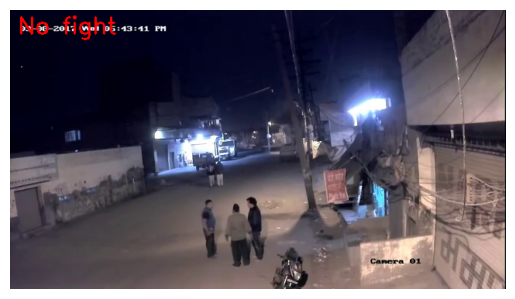

1/1 [==============================] - 0s 37ms/step
[[7.0668134e-04 9.9929333e-01]]


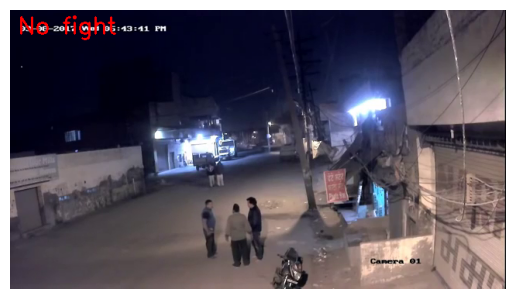

1/1 [==============================] - 0s 36ms/step
[[5.051279e-04 9.994949e-01]]


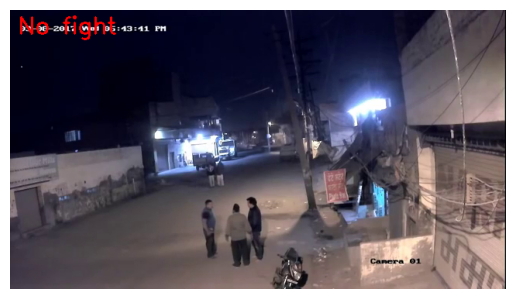

1/1 [==============================] - 0s 43ms/step
[[4.9738440e-04 9.9950266e-01]]


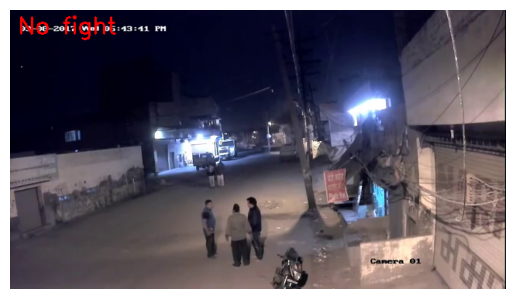

1/1 [==============================] - 0s 37ms/step
[[6.3431740e-04 9.9936575e-01]]


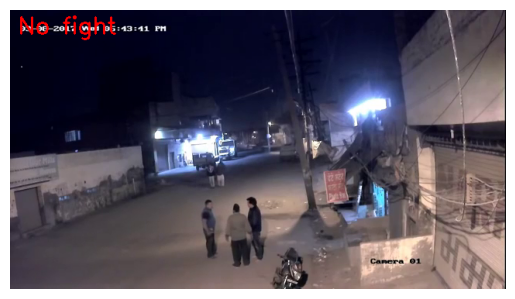

1/1 [==============================] - 0s 53ms/step
[[5.3177139e-04 9.9946827e-01]]


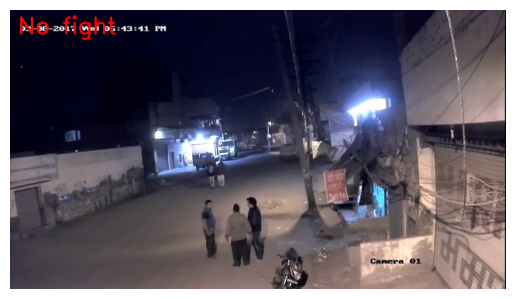

1/1 [==============================] - 0s 39ms/step
[[4.5944712e-04 9.9954057e-01]]


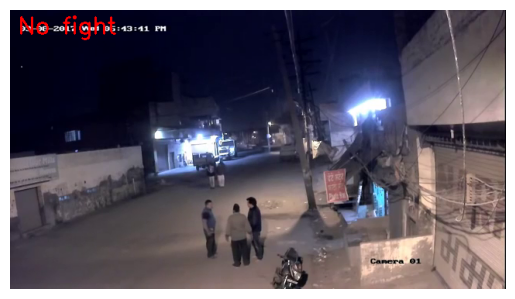

1/1 [==============================] - 0s 51ms/step
[[4.550252e-04 9.995449e-01]]


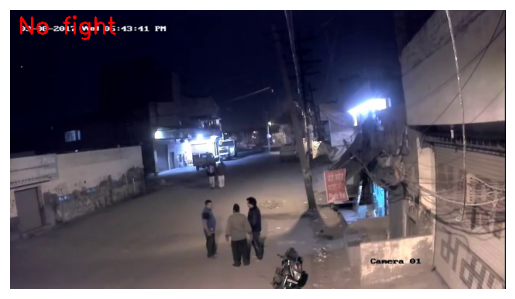

1/1 [==============================] - 0s 68ms/step
[[5.976290e-04 9.994024e-01]]


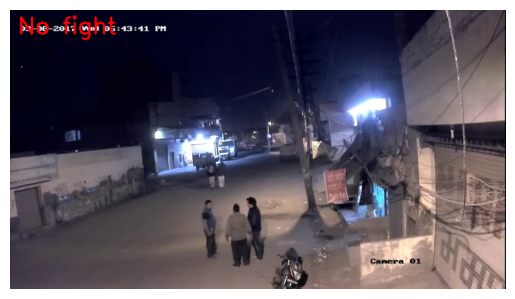

1/1 [==============================] - 0s 53ms/step
[[5.431716e-04 9.994568e-01]]


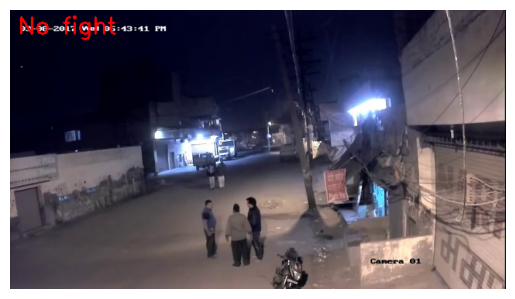

1/1 [==============================] - 0s 67ms/step
[[6.061262e-04 9.993938e-01]]


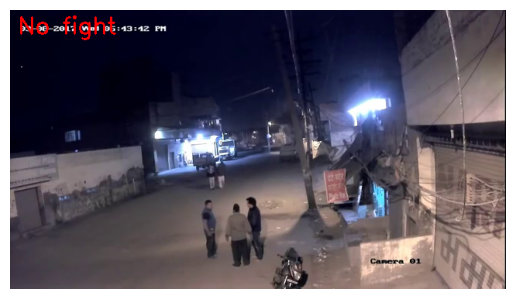

1/1 [==============================] - 0s 39ms/step
[[4.352557e-04 9.995647e-01]]


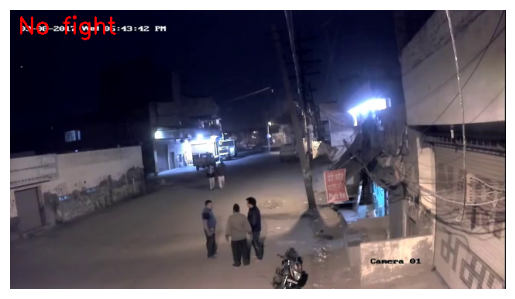

1/1 [==============================] - 0s 58ms/step
[[5.168434e-04 9.994831e-01]]


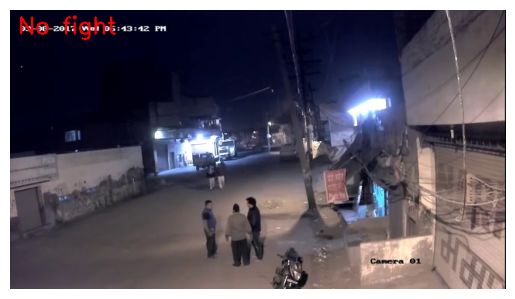

1/1 [==============================] - 0s 38ms/step
[[6.1719888e-04 9.9938273e-01]]


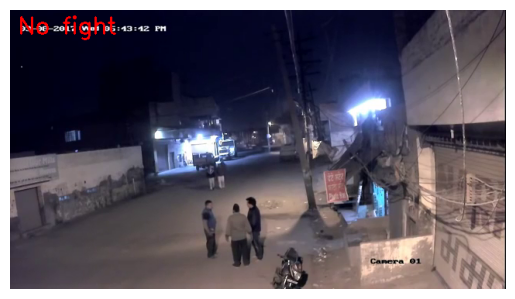

In [ ]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Load the video file
video_path = '/content/drive/MyDrive/parkavi/noFight/nofi007.mp4'
video = cv2.VideoCapture(video_path)

# Create a function to preprocess the frame
def preprocess(frame):
    # Resize the frame if needed
    # processed_frame = cv2.resize(frame, (width, height))

    # Preprocess the frame (e.g., resize, normalize, etc.)
    resized_frame = cv2.resize(frame, (224, 224))
    normalized_frame = resized_frame / 255.0
    input_frame = normalized_frame.reshape(1, 224, 224, 3)
    return input_frame

# Create a function to process and display the video
def process_video(video):
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        # Preprocess the frame
        processed_frame = preprocess(frame)

        # Make a prediction on the processed frame
        prediction = model.predict(processed_frame)

        # Determine the class label based on the prediction
        print(prediction)
        if prediction[0][0]>0.5:
            label = 'Fighting recorded'
        else:
            label = 'No fight'

        # Overlay the label on the frame
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video object
    video.release()
    cv2.destroyAllWindows()

# Process and display the video
process_video(video)


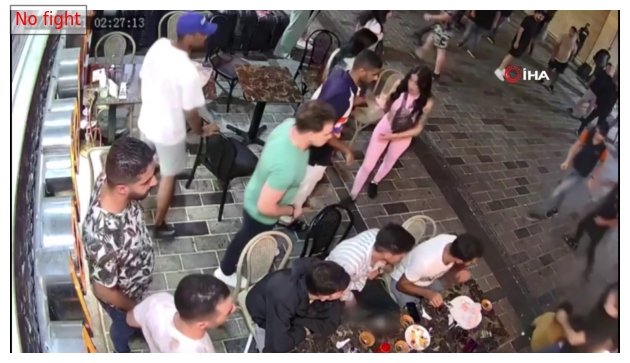

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the video file
#video_path = '/content/drive/MyDrive/parkavi/fight/fi002.mp4'
video_path = '/content/drive/MyDrive/parkavi/V2.mp4'

video = cv2.VideoCapture(video_path)

# Create a function to preprocess the frame
def preprocess(frame):
    # Resize the frame if needed
    # processed_frame = cv2.resize(frame, (width, height))

    # Preprocess the frame (e.g., resize, normalize, etc.)
    resized_frame = cv2.resize(frame, (224, 224))
    normalized_frame = resized_frame / 255.0
    input_frame = normalized_frame.reshape(1, 224, 224, 3)
    return input_frame

# Create a function to process and display the video
def process_video(video):
    fig, ax = plt.subplots()
    plt.axis('off')  # Turn off axes
    plt.tight_layout()  # Ensure tight layout

    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        # Preprocess the frame
        processed_frame = preprocess(frame)

        # Make a prediction on the processed frame
        prediction = model.predict(processed_frame, verbose=0)

        # Determine the class label based on the prediction
        if prediction[0][0] >= 0.5:
            label = 'Fighting recorded'
        else:
            label = 'No fight'

        # Overlay the label on the frame
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        ax.text(10, 30, label, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

        # Update the plot
        plt.pause(0.001)
        plt.show()  # Display the plot

        # Clear the previous frame
        ax.cla()

    # Release the video object
    video.release()
    plt.close(fig)  # Close the figure to avoid multiple plots

# Process and display the video
process_video(video)


In [ ]:
count=0
#for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
  #print(filename)
vidObj = cv2.VideoCapture('/content/drive/MyDrive/parkavi/V7.mp4')
print(vidObj)
while True:
        success, image = vidObj.read()
        #print(success)
        # Saves the frames with frame-count
        if success:
          cv2.resize(image,(299,299));
          cv2.imwrite("/content/drive/MyDrive/parkavi/t/frame%d.jpg" % count, image)
          count += 1
        else:
          break
vidObj.release()
cv2.destroyAllWindows()

< cv2.VideoCapture 0x7f1c18cc2310>


In [ ]:
for image1 in os.listdir('/content/drive/MyDrive/parkavi/t'):
  image = cv2.imread(os.path.join('/content/drive/MyDrive/parkavi/t',image1))
  if image is not None:
      #x = image.img_to_array(img)
      x = np.expand_dims(image, axis=0)

      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      print(classes[0])
      if classes[0][1]<=0:
          print("Fighting recorded")
      else:
          print("No fight")

1/1 [==============================] - 3s 3s/step
[0. 1.]
No fight
1/1 [==============================] - 0s 28ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 31ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 29ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 27ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 28ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 26ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 27ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 26ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 27ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 31ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 49ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 29ms/step
[0. 1.]
No fight
1/1 [==============================] - 0s 29ms/step
[0. 1.]
No fight
1/1 [==============================]

In [ ]:
for image1 in os.listdir('/content/drive/MyDrive/parkavi/tf'):
  image = cv2.imread(os.path.join('/content/drive/MyDrive/parkavi/tf',image1))
  if image is not None:
      #x = image.img_to_array(img)
      x = np.expand_dims(image, axis=0)

      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      print(classes[0])
      if classes[0][1]<=0:
          print("Fighting recorded")
      else:
          print("No fight")

1/1 [==============================] - 1s 1s/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 37ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 37ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 30ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 31ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 30ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 31ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 31ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 32ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 29ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 32ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 32ms/step
[1. 0.]
Fighting recorded
1/1 [==============================] - 0s 37ms/step
[1. 0.]
Fighti

In [ ]:
for image1 in os.listdir('/content/drive/MyDrive/parkavi/tnf'):
  image = cv2.imread(os.path.join('/content/drive/MyDrive/parkavi/tnf',image1))
  if image is not None:
      #x = image.img_to_array(img)
      x = np.expand_dims(image, axis=0)

      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      print(classes[0])
      if classes[0][1]<=0:
          print("Fighting recorded")
      else:

          print("No fight")

[1.0000000e+00 4.5855546e-30]
No fight
[1.0000000e+00 3.3385476e-30]
No fight
[1.0000000e+00 1.4318548e-30]
No fight
[1.0000000e+00 1.0810763e-30]
No fight
[1.000000e+00 1.623806e-28]
No fight
[1.0000000e+00 3.1338524e-27]
No fight
[1.0000000e+00 2.4453542e-26]
No fight
[1.00000e+00 1.76583e-26]
No fight
[1.0000000e+00 4.7163494e-26]
No fight
[1.0000000e+00 2.2664637e-25]
No fight
[1.0000000e+00 1.5963691e-22]
No fight
[1.0000000e+00 2.1295145e-22]
No fight
[1.000000e+00 7.888478e-22]
No fight
[1.000000e+00 7.101276e-21]
No fight
[1.0000000e+00 1.5451028e-20]
No fight
[1.0000000e+00 2.4709987e-20]
No fight
[1.0000000e+00 1.6974635e-18]
No fight
[1.0000000e+00 1.3941134e-18]
No fight
[1.0000000e+00 1.1520316e-19]
No fight
[1.0000000e+00 2.2480094e-19]
No fight
[1.0000000e+00 4.1106737e-20]
No fight
[1.00000e+00 3.03513e-19]
No fight
[1.000000e+00 4.859754e-19]
No fight
[1.0000000e+00 5.9148105e-20]
No fight
[1.0000000e+00 3.2888904e-18]
No fight
[1.000000e+00 6.593419e-19]
No fight
[1.0